# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import model1
from data import DataCollector
import matplotlib.pyplot as plt
import numpy as np
from torchinfo import summary
import torch

In [20]:
# torch.cuda.set_per_process_memory_fraction(0.8)
# I have trouble what should I do
# as for validation accuracy I think we should give up
# as for testing, we wanna use the test dataloader of trashnet(<-fine) 
# and the hand-held actual data(at least 10 for each category)
# 
# suggestion put more focus on handd
# as for dataset how we should split?

In [29]:
# t = torch.cuda.get_device_properties(0).total_memory
# r = torch.cuda.memory_reserved(0)
# a = torch.cuda.memory_allocated(0)
# f = r-a  # free inside reserved
# print(t/1e9,r/1e9,a/1e9,f/1e9)

42.33101312 37.855690752 36.240246272 1.61544448


In [22]:
# torch.cuda.reset_max_memory_allocated(0)
# import gc
# del datasets
# del model
# torch.cuda.empty_cache()
# gc.collect()

# Data

## Configuration

In [3]:
height = 512
width = 384
classes = {"cardboard":(0, 403),
        "glass":(1, 501),
        "metal":(2, 410),
        "paper":(3, 594),
        "plastic":(4, 482)}

classes_original = {"cardboard":(0, 34),
        "glass":(1, 20),
        "metal":(2, 26),
        "paper":(3, 42),
        "plastic":(4, 33)}

        # "trash":(5, 137)}
# numlimit = 200
# classes = {"cardboard":(0, numlimit),
#         "glass":(1, numlimit),
#         "metal":(2, numlimit),
#         "paper":(3, numlimit),
#         "plastic":(4, numlimit),
#         "trash":(5, min(137,numlimit))}

skin_tones = {0:(41, 23, 9),#darker
              1:(95, 51, 16),
              2:(127, 68, 34),
              3:(178, 102, 68),
              4:(115, 63, 23),
              5:(147, 95, 55),
              6:(173, 138, 96),
              7:(207, 150, 95),
              8:(187, 101, 54),
              9:(212, 158, 122),
              11:(242, 194, 128),
              12:(236, 192, 145),
              13:(249, 212, 160),
              14:(248, 217, 152),
              15:(253, 231, 173),
              16:(254, 227, 197)}#paler

## datasets

In [4]:
collector1 = DataCollector(height, width, classes)
datasets1 = collector1.collect('trashnet/dataset-resized',resnet_label = 34, val_size=0.2, test_size=0.2)

Store in X and y


In [5]:
collector2 = DataCollector(height, width, classes,mask_opts = {"mask_size":100,"skintone_label":15,})
datasets2 = collector2.collect('trashnet/dataset-resized',resnet_label=34, val_size=0.2, test_size=0.2)

Store in X and y


In [6]:
collector3 = DataCollector(height, width, classes_original)
datasets3 = collector3.collect('original_trashnet/original_dataset',resnet_label = 34, val_size=0.25, test_size=0.5,class_balanced=False)

Store in X and y


In [7]:

datasets4={}

for datatype in ['train','val','test']:
    
    X2,y2 = next(iter(torch.utils.data.DataLoader(dataset=datasets2[datatype], batch_size =150, shuffle = True)))
    X3,y3 = next(iter(torch.utils.data.DataLoader(dataset=datasets3[datatype], batch_size = len(datasets3[datatype]), shuffle = False)))
    
    datasets4[datatype] = torch.utils.data.TensorDataset(torch.cat((X2,X3)), torch.cat((y2,y3)))



# Model 1

## Construction

In [8]:
unique_filename_model1_unfreeze_1 = "seqno7_model1_train_final_layer"

In [96]:
model = model1.Model(
    height=height,
    width=width,
    num_classes=len(classes),
    lr=0.05,
    bs = 64,
    rho = 0.9,
    gamma_step = 7,
    gamma = 0.5,
    num_active_layers = 5,#
    free_all = False,
    if_replace = True,
    workers = 1,
    epochs = 100,
    mask = False,
    unique_filename = unique_filename_model1_unfreeze_1,
    model_type = 1,
    model_weights_ref_path = "ResNet34_Weights.pth"
    )
train_data_loader = model.construct_data(datasets1)

In [98]:
# train_data_loader = model.construct_data(datasets1)
# inputs,labels = next(iter(train_data_loader))

In [94]:
# # del model.model.parameters()
# import gc
# gc.collect()
model.test_against_newdata(datasets1['test']),model.test_against_newdata(datasets2['test']),model.test_against_newdata(datasets3['test'])

((33.51210403442383, tensor(0.1778)),
 (33.51210403442383, tensor(0.1778)),
 (26.087142944335938, tensor(0.1923)))

## Training

In [99]:
_, avg_training_loss, avg_training_accuracy, validation_loss, validation_accuracy = model.train()
#epoch stop when the validation accuracy reached toovercome overlearning

HELLO
Epoch:   1 	 Training Loss: 2.00772 	 Training Accuracy: 0.33560 	 Validation Loss: 1.85640 	 Validation Accuracy: 0.38494
Epoch:   2 	 Training Loss: 2.18044 	 Training Accuracy: 0.33377 	 Validation Loss: 1350349.87500 	 Validation Accuracy: 0.17364
Epoch:   3 	 Training Loss: 1.91370 	 Training Accuracy: 0.32964 	 Validation Loss: 7.25939 	 Validation Accuracy: 0.29498
Epoch:   4 	 Training Loss: 1.46271 	 Training Accuracy: 0.40076 	 Validation Loss: 2.12050 	 Validation Accuracy: 0.29079
Epoch:   5 	 Training Loss: 1.40228 	 Training Accuracy: 0.44633 	 Validation Loss: 2.11140 	 Validation Accuracy: 0.42678
Epoch:   6 	 Training Loss: 1.31442 	 Training Accuracy: 0.45490 	 Validation Loss: 1.34478 	 Validation Accuracy: 0.44561
Epoch:   7 	 Training Loss: 1.36610 	 Training Accuracy: 0.45020 	 Validation Loss: 1.45265 	 Validation Accuracy: 0.41632
Epoch:   8 	 Training Loss: 1.27038 	 Training Accuracy: 0.48129 	 Validation Loss: 1.33743 	 Validation Accuracy: 0.46444
Epoc

In [100]:
test_loss, test_accuracy = model.test()
test_loss, test_accuracy

tensor([3, 1, 4, 1, 3, 3, 1, 1, 3, 4, 3, 2, 3, 4, 0, 2, 3, 0, 3, 1, 1, 3, 4, 4,
        3, 2, 4, 2, 1, 3, 2, 2, 0, 4, 2, 4, 3, 3, 1, 1, 3, 0, 1, 3, 4, 0, 2, 0,
        4, 2, 1, 3, 0, 4, 1, 2, 0, 0, 0, 4, 1, 4, 2, 1, 3, 3, 4, 2, 4, 4, 4, 0,
        0, 3, 1, 1, 3, 4, 2, 1, 0, 3, 1, 3, 1, 1, 3, 3, 0, 1, 3, 1, 1, 2, 2, 3,
        4, 1, 0, 0, 2, 3, 3, 2, 2, 1, 1, 2, 3, 3, 0, 0, 0, 0, 0, 2, 3, 0, 1, 4,
        2, 3, 2, 4, 2, 4, 2, 3, 0, 2, 2, 4, 1, 0, 0, 1, 4, 1, 2, 3, 4, 1, 0, 3,
        1, 0, 1, 2, 3, 3, 2, 1, 4, 3, 4, 0, 3, 4, 3, 2, 2, 2, 1, 3, 4, 2, 1, 0,
        1, 1, 1, 1, 3, 4, 1, 0, 0, 3, 2, 4, 4, 3, 3, 4, 3, 4, 1, 3, 3, 0, 3, 0,
        3, 4, 3, 2, 3, 2, 0, 0, 3, 4, 3, 3, 4, 1, 2, 4, 4, 1, 3, 4, 0, 3, 3, 2,
        3, 3, 0, 1, 2, 1, 0, 3, 3, 3, 4, 1, 4, 2, 3, 4, 3, 3, 4, 0, 1, 4, 3, 4,
        2, 2, 1, 2, 1, 3, 3, 0, 0, 1, 1, 2, 1, 0, 4, 1, 3, 1, 0, 3, 4, 3, 3, 0,
        3, 1, 0, 3, 2, 2, 3, 4, 0, 3, 3, 4, 2, 3, 2, 1, 3, 4, 2, 1, 0, 3, 3, 3,
        2, 3, 2, 1, 4, 0, 4, 4, 0, 1, 3,

(1.9259289503097534, tensor(0.5460))

In [129]:
model.test_against_newdata(datasets1['test']),model.test_against_newdata(datasets2['test']),model.test_against_newdata(datasets3['test'])

((1.9259289503097534, tensor(0.5460)),
 (1.8931465148925781, tensor(0.5460)),
 (2.543203592300415, tensor(0.3077)))

In [58]:
t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
f = r-a  # free inside reserved
t,r,a,f

(42331013120, 41378906112, 12164796416, 29214109696)

# Model2 with mask

## data collection with mask

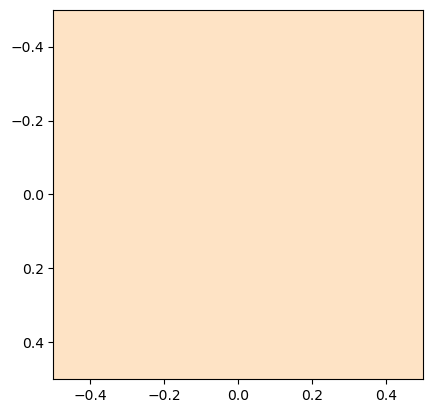

In [131]:
plt.imshow(np.expand_dims(np.array(skin_tones[16]),axis = (0,1)))
plt.show()

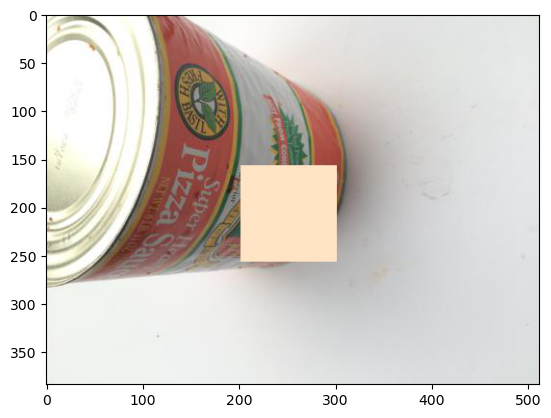

In [127]:
from PIL import Image
image = np.array(Image.open('trashnet/dataset-resized/metal/metal1.jpg'))
mask_size = 100
j = np.random.randint(width-mask_size)
k = np.random.randint(height-mask_size)
image[j:j+mask_size,k:k+mask_size] = skin_tones[16]
plt.imshow(image)
plt.show()

In [132]:
# collector2 = DataCollector(height, width, classes,mask_opts = {"mask_size":20,"skintone_label":20,})
# datasets2 = collector2.collect('trashnet/dataset-resized',resnet_label=34, val_size=0.2, test_size=0.2)

model2 = model1.Model(
height=height,
width=width,
num_classes=len(classes),
lr=0.001,
bs = 64,
rho = 0.9,
gamma_step = 7,
gamma = 0.9,
num_active_layers = 5,
free_all = False,
if_replace = True,
workers = 1,
epochs = 15,
mask = True,
unique_filename = "seqno6_model2",
model_type = 2,
model_weights_ref_path = f'models/{unique_filename_model1_unfreeze_1}/model.pth'
)
model2.construct_data(datasets2)
# print(i)
print("model2_test_acc_against1",model2.test_against_newdata(datasets1['test']))
print( "model2_test_acc_against2",model2.test_against_newdata(datasets2['test']))
print("model2_test_acc_against3",model2.test_against_newdata(datasets3['test']))
_, avg_training_loss, avg_training_accuracy, validation_loss, validation_accuracy = model2.train()
print("model2_test_acc_against1",model2.test_against_newdata(datasets1['test']))
print("model2_test_acc_against2",model2.test_against_newdata(datasets2['test']))
print("model2_test_acc_against3",model2.test_against_newdata(datasets3['test']))

95
model2_test_acc_against1 (1.9259289503097534, tensor(0.5460))
model2_test_acc_against2 (2.0426602363586426, tensor(0.5586))
model2_test_acc_against3 (2.543203592300415, tensor(0.3077))
HELLO
Epoch:   1 	 Training Loss: 0.83237 	 Training Accuracy: 0.67140 	 Validation Loss: 1.85158 	 Validation Accuracy: 0.52301
Epoch:   2 	 Training Loss: 0.79080 	 Training Accuracy: 0.68431 	 Validation Loss: 1.41116 	 Validation Accuracy: 0.53138
Epoch:   3 	 Training Loss: 0.80303 	 Training Accuracy: 0.68672 	 Validation Loss: 1.47574 	 Validation Accuracy: 0.54184
Epoch:   4 	 Training Loss: 0.75190 	 Training Accuracy: 0.71656 	 Validation Loss: 1.40683 	 Validation Accuracy: 0.52720
Epoch:   5 	 Training Loss: 0.77769 	 Training Accuracy: 0.69325 	 Validation Loss: 1.52772 	 Validation Accuracy: 0.55649
Epoch:   6 	 Training Loss: 0.75448 	 Training Accuracy: 0.69116 	 Validation Loss: 1.52122 	 Validation Accuracy: 0.52720
Epoch:   7 	 Training Loss: 0.73902 	 Training Accuracy: 0.71284 	 V

In [24]:
# for i in range(20,100,15):
#     collector2 = DataCollector(height, width, classes,mask_opts = {"mask_size":20,"skintone_label":i,})
#     datasets2 = collector2.collect('trashnet/dataset-resized',resnet_label=34, val_size=0.2, test_size=0.2)
    
#     model2 = model1.Model(
#     height=height,
#     width=width,
#     num_classes=len(classes),
#     lr=0.001,
#     bs = 64,
#     rho = 0.9,
#     gamma_step = 0.5,
#     gamma = 0.9,
#     num_active_layers = 5,
#     free_all = False,
#     if_replace = True,
#     workers = 1,
#     epochs = 15,
#     mask = True,
#     unique_filename = "seqno5_model2",
#     model_type = 2,
#     model_weights_ref_path = f'models/{unique_filename_model1_unfreeze_1}/model.pth'
#     )
#     model2.construct_data(datasets2)
#     print(i)
#     print("model2_test_acc_against1",model2.test_against_newdata(datasets1['test']))
#     print( "model2_test_acc_against2",model2.test_against_newdata(datasets2['test']))
#     print("model2_test_acc_against3",model2.test_against_newdata(datasets3['test']))
#     _, avg_training_loss, avg_training_accuracy, validation_loss, validation_accuracy = model2.train()
#     print("model2_test_acc_against1",model2.test_against_newdata(datasets1['test']))
#     print("model2_test_acc_against2",model2.test_against_newdata(datasets2['test']))
#     print("model2_test_acc_against3",model2.test_against_newdata(datasets3['test']))

In [19]:
# _, avg_training_loss, avg_training_accuracy, validation_loss, validation_accuracy = model2.train()

HELLO
Epoch:   1 	 Training Loss: 0.32739 	 Training Accuracy: 0.94884 	 Validation Loss: 1.04497 	 Validation Accuracy: 0.60669
Epoch:   2 	 Training Loss: 0.23981 	 Training Accuracy: 0.97931 	 Validation Loss: 1.05682 	 Validation Accuracy: 0.60251
Epoch:   3 	 Training Loss: 0.18696 	 Training Accuracy: 0.98814 	 Validation Loss: 1.04946 	 Validation Accuracy: 0.60879
Epoch:   4 	 Training Loss: 0.15167 	 Training Accuracy: 0.98887 	 Validation Loss: 1.08175 	 Validation Accuracy: 0.60251
Epoch:   5 	 Training Loss: 0.11473 	 Training Accuracy: 0.99524 	 Validation Loss: 1.07681 	 Validation Accuracy: 0.60669
Epoch:   6 	 Training Loss: 0.09396 	 Training Accuracy: 0.99629 	 Validation Loss: 1.09026 	 Validation Accuracy: 0.60251
Epoch:   7 	 Training Loss: 0.08263 	 Training Accuracy: 0.99629 	 Validation Loss: 1.09958 	 Validation Accuracy: 0.60042
Epoch:   8 	 Training Loss: 0.06920 	 Training Accuracy: 0.99796 	 Validation Loss: 1.09896 	 Validation Accuracy: 0.60042
Epoch:   9

In [20]:
# test_loss, test_accuracy = model2.test()
# test_loss, test_accuracy

(0.9934713244438171, tensor(0.6234))

In [21]:
# model2.test_against_newdata(datasets1['test']),model2.test_against_newdata(datasets2['test']),model2.test_against_newdata(datasets3['test'])

((0.9934713244438171, tensor(0.6234)),
 (0.9934713244438171, tensor(0.6234)),
 (2.545992612838745, tensor(0.1923)))

## model3 against actual training

In [11]:
# collector3 = DataCollector(height, width, classes_original)
# datasets3 = collector3.collect('original_trashnet/original_dataset',resnet_label = 34, val_size=0.25, test_size=0.5,class_balanced=True)

Store in X and y


In [12]:
unique_filename_model2 = "seqno6_model2"
model3 = model1.Model(
    height=height,
    width=width,
    num_classes=len(classes),
    lr=0.001,
    bs = 16,
    rho = 0.9,
    gamma_step = 7,
    gamma = 0.9,
    num_active_layers = 5,
    free_all = False,
    if_replace = True,
    workers = 1,
    epochs = 30,
    mask = True,
    unique_filename = "seqno6_model3",
    model_type = 2,
    model_weights_ref_path = f'models/{unique_filename_model2}/model.pth'
    )

In [13]:
model3.construct_data(datasets3)

In [14]:
_, avg_training_loss, avg_training_accuracy, validation_loss, validation_accuracy = model3.train()

HELLO
Epoch:   1 	 Training Loss: 2.42657 	 Training Accuracy: 0.29861 	 Validation Loss: 2.31728 	 Validation Accuracy: 0.30769
Epoch:   2 	 Training Loss: 2.05468 	 Training Accuracy: 0.38889 	 Validation Loss: 2.18211 	 Validation Accuracy: 0.30769
Epoch:   3 	 Training Loss: 1.40606 	 Training Accuracy: 0.54861 	 Validation Loss: 2.79341 	 Validation Accuracy: 0.20513
Epoch:   4 	 Training Loss: 1.11010 	 Training Accuracy: 0.56250 	 Validation Loss: 3.47504 	 Validation Accuracy: 0.20513
Epoch:   5 	 Training Loss: 1.16817 	 Training Accuracy: 0.72222 	 Validation Loss: 3.56923 	 Validation Accuracy: 0.23077
Epoch:   6 	 Training Loss: 0.78697 	 Training Accuracy: 0.68056 	 Validation Loss: 3.56358 	 Validation Accuracy: 0.38462
Epoch:   7 	 Training Loss: 0.73502 	 Training Accuracy: 0.77778 	 Validation Loss: 3.43475 	 Validation Accuracy: 0.38462
Epoch:   8 	 Training Loss: 0.65463 	 Training Accuracy: 0.80556 	 Validation Loss: 3.06292 	 Validation Accuracy: 0.41026
Epoch:   9

In [15]:
model3.test_against_newdata(datasets1['test']),model3.test_against_newdata(datasets2['test']),model3.test_against_newdata(datasets3['test'])

((40.51995849609375, tensor(0.2741)),
 (43.36581802368164, tensor(0.2887)),
 (3.283695697784424, tensor(0.3333)))

In [16]:
test_loss, test_accuracy = model3.test()
test_loss, test_accuracy

tensor([2, 3, 1, 3, 3, 0, 2, 3, 0, 3, 0, 4, 3, 3, 2, 2, 3, 2, 1, 0, 4, 3, 1, 3,
        2, 3, 0, 2, 4, 1, 4, 4, 3, 2, 3, 2, 3, 3, 0, 0, 3, 4, 0, 0, 3, 3, 4, 2,
        3, 3, 3, 2, 1, 3, 3, 2, 3, 1, 2, 3, 4, 4, 3, 4, 2, 3, 3, 3, 3, 4, 4, 1,
        0, 2, 3, 2, 2, 0], device='cuda:0') tensor([2, 3, 1, 4, 1, 0, 3, 3, 1, 4, 2, 3, 1, 3, 3, 3, 3, 2, 1, 0, 1, 3, 0, 2,
        0, 3, 3, 2, 4, 0, 0, 0, 4, 4, 0, 4, 2, 3, 0, 2, 3, 3, 2, 2, 2, 3, 2, 2,
        0, 3, 3, 0, 4, 0, 0, 4, 1, 4, 4, 2, 4, 4, 1, 3, 2, 4, 0, 3, 4, 3, 3, 2,
        1, 0, 0, 0, 3, 0], device='cuda:0')


(3.283695697784424, tensor(0.3333))

## model4 trained against mixed data at the 2nd step

In [162]:
model4 = model1.Model(
height=height,
width=width,
num_classes=len(classes),
lr=0.001,
bs = 64,
rho = 0.9,
gamma_step = 15,
gamma = 0.8,
num_active_layers = 5,
free_all = False,
if_replace = True,
workers = 1,
epochs = 100,
mask = True,
unique_filename = "seqno6_model4",
model_type = 2,
model_weights_ref_path = f'models/{unique_filename_model1_unfreeze_1}/model.pth'
)
model4.construct_data(datasets4)


In [ ]:
# print(i)
print("model2_test_acc_against1",model4.test_against_newdata(datasets1['test']))
print( "model2_test_acc_against2",model4.test_against_newdata(datasets2['test']))
print("model2_test_acc_against3",model4.test_against_newdata(datasets3['test']))
_, avg_training_loss, avg_training_accuracy, validation_loss, validation_accuracy = model4.train()
print("model2_test_acc_against1",model4.test_against_newdata(datasets1['test']))
print("model2_test_acc_against2",model4.test_against_newdata(datasets2['test']))
print("model2_test_acc_against3",model4.test_against_newdata(datasets3['test']))
## as for the final part, there is a corresponding screenshot
## overallに良い感じだ！

model2_test_acc_against1 (1.9259289503097534, tensor(0.5460))
model2_test_acc_against2 (2.0426602363586426, tensor(0.5586))
model2_test_acc_against3 (2.543203592300415, tensor(0.3077))
HELLO
Epoch:   1 	 Training Loss: 1.20282 	 Training Accuracy: 0.62153 	 Validation Loss: 1.72243 	 Validation Accuracy: 0.51323
Epoch:   2 	 Training Loss: 1.08662 	 Training Accuracy: 0.62778 	 Validation Loss: 1.75503 	 Validation Accuracy: 0.49206
Epoch:   3 	 Training Loss: 1.00858 	 Training Accuracy: 0.59062 	 Validation Loss: 1.78334 	 Validation Accuracy: 0.44444
Epoch:   4 	 Training Loss: 0.90296 	 Training Accuracy: 0.69132 	 Validation Loss: 1.82023 	 Validation Accuracy: 0.44974
Epoch:   5 	 Training Loss: 0.82096 	 Training Accuracy: 0.70278 	 Validation Loss: 1.81874 	 Validation Accuracy: 0.43386
Epoch:   6 	 Training Loss: 0.78339 	 Training Accuracy: 0.70312 	 Validation Loss: 1.82342 	 Validation Accuracy: 0.43386
Epoch:   7 	 Training Loss: 0.79432 	 Training Accuracy: 0.70278 	 Vali

> result
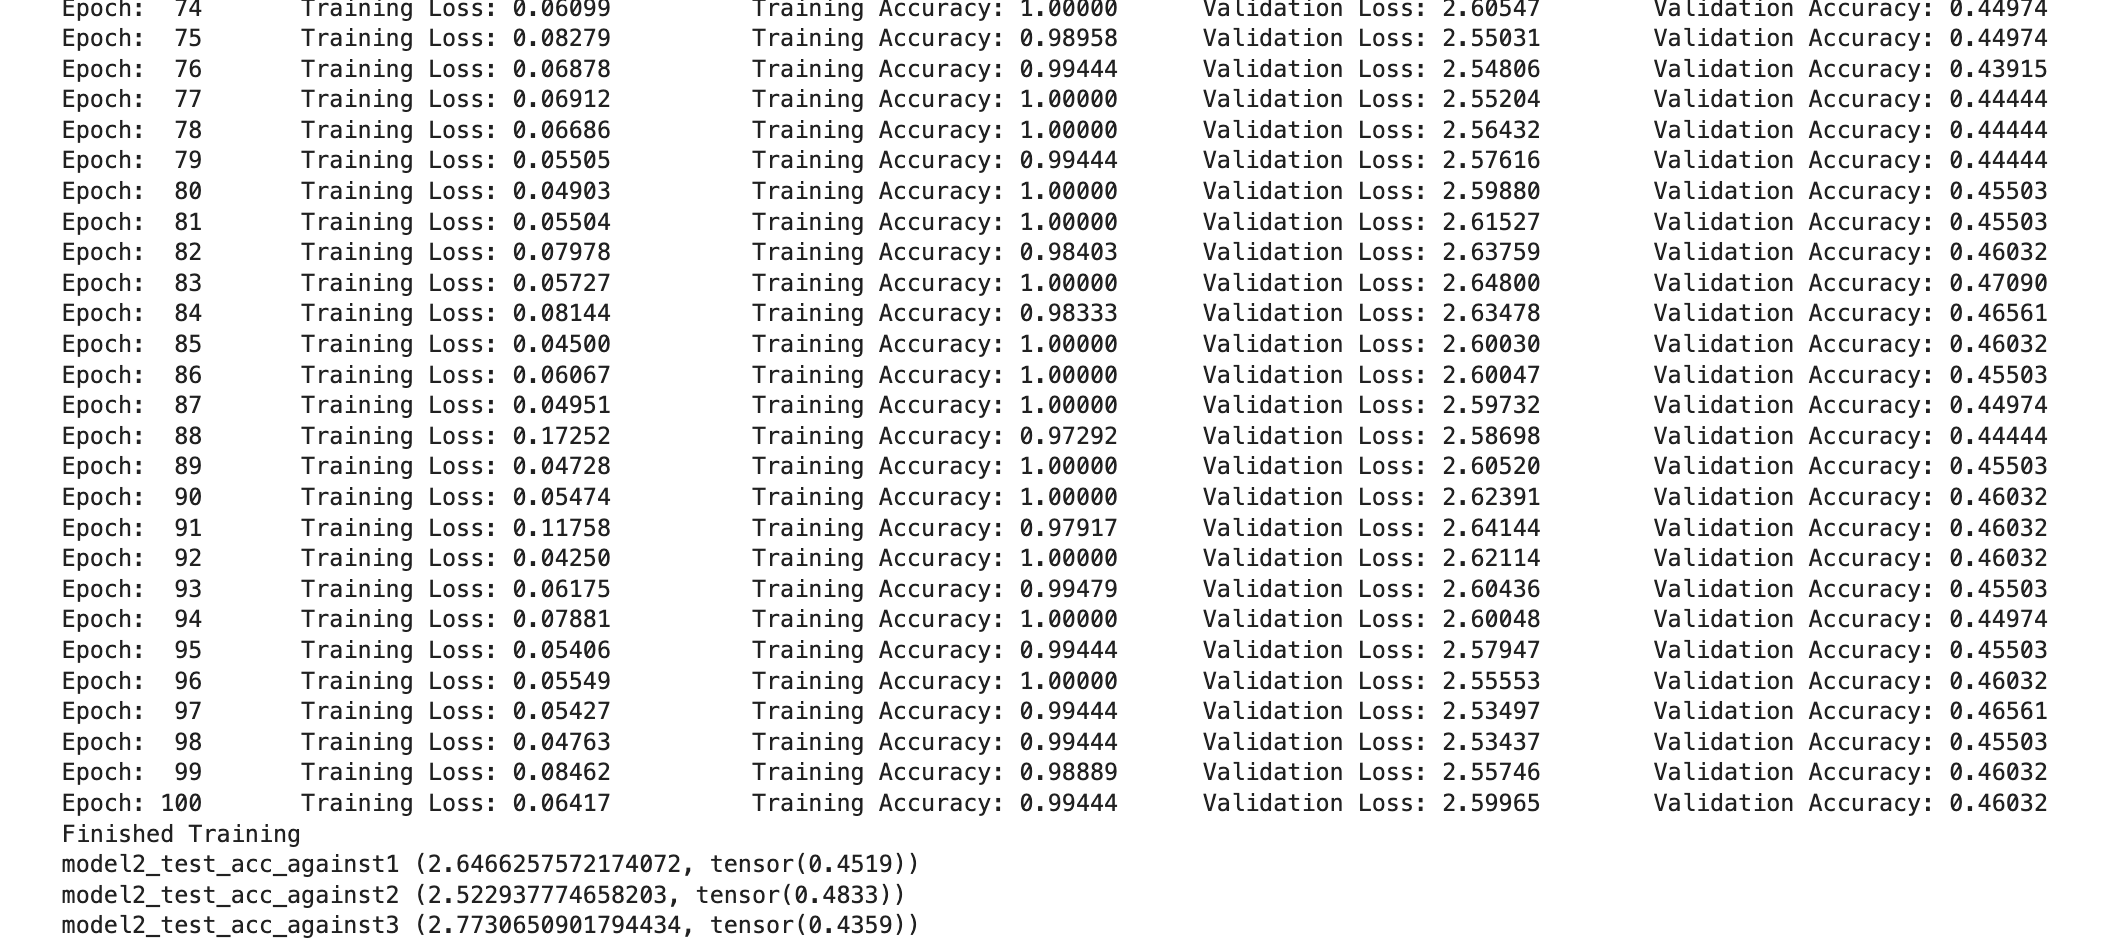

## model5 trained against mixed data  at the 1st step

In [43]:
# del model5.model.parameters().to('cpu')
import gc
gc.collect()

26020

In [45]:
torch.cuda.empty_cache()

In [50]:
unique_filename_model1_unfreeze_1 = "seqno6_model5_dataset4_1st_step"
model5 = model1.Model(
    height=height,
    width=width,
    num_classes=len(classes),
    lr=0.05,
    bs = 16,#200
    rho = 0.9,
    gamma_step = 7,
    gamma = 0.5,
    num_active_layers = 5,#
    free_all = False,
    if_replace = True,
    workers = 1,
    epochs = 100,
    mask = False,
    unique_filename = unique_filename_model1_unfreeze_1,
    model_type = 1,
    model_weights_ref_path = "ResNet34_Weights.pth"
    )
train_data_loader = model5.construct_data(datasets4)

print("model5_test_acc_against1",model5.test_against_newdata(datasets1['test']))
print( "model5_test_acc_against2",model5.test_against_newdata(datasets2['test']))
print("model5_test_acc_against3",model5.test_against_newdata(datasets3['test']))

_, avg_training_loss, avg_training_accuracy, validation_loss, validation_accuracy = model5.train()

print("model5_test_acc_against1",model5.test_against_newdata(datasets1['test']))
print( "model5_test_acc_against2",model5.test_against_newdata(datasets2['test']))
print("model5_test_acc_against3",model5.test_against_newdata(datasets3['test']))


model5_test_acc_against1 (11.759663581848145, tensor(0.2678))
model5_test_acc_against2 (11.616233825683594, tensor(0.2699))
model5_test_acc_against3 (11.091633796691895, tensor(0.2692))
HELLO
Epoch:   1 	 Training Loss: 4.31565 	 Training Accuracy: 0.24479 	 Validation Loss: 601313.62500 	 Validation Accuracy: 0.13757
Epoch:   2 	 Training Loss: 2.66741 	 Training Accuracy: 0.19444 	 Validation Loss: 334.27539 	 Validation Accuracy: 0.23280
Epoch:   3 	 Training Loss: 2.34668 	 Training Accuracy: 0.23611 	 Validation Loss: 14.06874 	 Validation Accuracy: 0.24339
Epoch:   4 	 Training Loss: 2.25430 	 Training Accuracy: 0.19965 	 Validation Loss: 21.55950 	 Validation Accuracy: 0.24868
Epoch:   5 	 Training Loss: 1.82653 	 Training Accuracy: 0.33681 	 Validation Loss: 4.11562 	 Validation Accuracy: 0.21693
Epoch:   6 	 Training Loss: 1.93007 	 Training Accuracy: 0.32986 	 Validation Loss: 2.15159 	 Validation Accuracy: 0.24868
Epoch:   7 	 Training Loss: 1.77486 	 Training Accuracy: 0.33

## Model 5' further trained against mixed data with less non-hand data

In [51]:
unique_filename_model1_unfreeze_1 = "seqno6_model5_dataset4_1st_step"
datasets5_1={}

for datatype in ['train','val','test']:
    
    X2,y2 = next(iter(torch.utils.data.DataLoader(dataset=datasets2[datatype], batch_size =50, shuffle = True)))
    X3,y3 = next(iter(torch.utils.data.DataLoader(dataset=datasets3[datatype], batch_size = len(datasets3[datatype]), shuffle = False)))
    
    datasets5_1[datatype] = torch.utils.data.TensorDataset(torch.cat((X2,X3)), torch.cat((y2,y3)))

In [53]:
model5_1 = model1.Model(
    height=height,
    width=width,
    num_classes=len(classes),
    lr=0.05,
    bs = 16,#200
    rho = 0.9,
    gamma_step = 7,
    gamma = 0.5,
    num_active_layers = 1,#
    free_all = False,
    if_replace = True,
    workers = 1,
    epochs = 100,
    mask = False,
    unique_filename = "seqno6_model5-1_dataset4",
    model_type = 2,
    model_weights_ref_path = f'models/{unique_filename_model1_unfreeze_1}/model.pth'
    )
model5_1.construct_data(datasets5_1)

# print("model5_test_acc_against1",model5_1.test_against_newdata(datasets1['test']))
# print( "model5_test_acc_against2",model5_1.test_against_newdata(datasets2['test']))
# print("model5_test_acc_against3",model5_1.test_against_newdata(datasets3['test']))

_, avg_training_loss, avg_training_accuracy, validation_loss, validation_accuracy = model5_1.train()



HELLO
Epoch:   1 	 Training Loss: 1.62492 	 Training Accuracy: 0.40625 	 Validation Loss: 1.70407 	 Validation Accuracy: 0.40449
Epoch:   2 	 Training Loss: 1.44739 	 Training Accuracy: 0.41667 	 Validation Loss: 1.94497 	 Validation Accuracy: 0.32584
Epoch:   3 	 Training Loss: 1.55496 	 Training Accuracy: 0.25000 	 Validation Loss: 1.99739 	 Validation Accuracy: 0.34831
Epoch:   4 	 Training Loss: 1.47741 	 Training Accuracy: 0.40625 	 Validation Loss: 1.76812 	 Validation Accuracy: 0.40449
Epoch:   5 	 Training Loss: 1.39474 	 Training Accuracy: 0.33333 	 Validation Loss: 1.77731 	 Validation Accuracy: 0.39326
Epoch:   6 	 Training Loss: 1.45203 	 Training Accuracy: 0.35417 	 Validation Loss: 1.72731 	 Validation Accuracy: 0.40449
Epoch:   7 	 Training Loss: 1.28003 	 Training Accuracy: 0.50000 	 Validation Loss: 1.81162 	 Validation Accuracy: 0.40449
Epoch:   8 	 Training Loss: 1.34273 	 Training Accuracy: 0.39583 	 Validation Loss: 1.89155 	 Validation Accuracy: 0.32584
Epoch:   9

In [55]:
print("model5-1_test_acc_against1",model5_1.test_against_newdata(datasets1['test']))
print( "model5-1_test_acc_against2",model5_1.test_against_newdata(datasets2['test']))
print("model5-1_test_acc_against3",model5_1.test_against_newdata(datasets3['test']))

model5-1_test_acc_against1 (1.915544867515564, tensor(0.3912))
model5-1_test_acc_against2 (1.974826693534851, tensor(0.4142))
model5-1_test_acc_against3 (2.417715311050415, tensor(0.3718))


## model6 trained against hand data at the 1st step

In [27]:
# torch.cuda.cache_clean()

torch.cuda.empty_cache()

In [19]:
unique_filename_model1_unfreeze_1 = "seqno6_model6_dataset3_1st_step"
model6 = model1.Model(
    height=height,
    width=width,
    num_classes=len(classes),
    lr=0.01,
    bs = 16,
    rho = 0.9,
    gamma_step = 7,
    gamma = 0.5,
    num_active_layers = 5,#
    free_all = False,
    if_replace = True,
    workers = 1,
    epochs = 20,
    mask = False,
    unique_filename = unique_filename_model1_unfreeze_1,
    model_type = 1,
    model_weights_ref_path = "ResNet34_Weights.pth"
    )
train_data_loader = model6.construct_data(datasets3)

print("model6_test_acc_against1",model6.test_against_newdata(datasets1['test']))
print( "model6_test_acc_against2",model6.test_against_newdata(datasets2['test']))
print("model6_test_acc_against3",model6.test_against_newdata(datasets3['test']))

_, avg_training_loss, avg_training_accuracy, validation_loss, validation_accuracy = model6.train()

print("model6_test_acc_against1",model6.test_against_newdata(datasets1['test']))
print("model6_test_acc_against2",model6.test_against_newdata(datasets2['test']))
print("model6_test_acc_against3",model6.test_against_newdata(datasets3['test']))

model6_test_acc_against1 (15.309691429138184, tensor(0.1820))
model6_test_acc_against2 (15.003049850463867, tensor(0.1757))
model6_test_acc_against3 (15.840222358703613, tensor(0.1410))
HELLO
Epoch:   1 	 Training Loss: 1.58284 	 Training Accuracy: 0.25694 	 Validation Loss: 2.25673 	 Validation Accuracy: 0.17949
Epoch:   2 	 Training Loss: 1.47688 	 Training Accuracy: 0.61111 	 Validation Loss: 2.65027 	 Validation Accuracy: 0.17949
Epoch:   3 	 Training Loss: 0.69675 	 Training Accuracy: 0.75000 	 Validation Loss: 2.56668 	 Validation Accuracy: 0.17949
Epoch:   4 	 Training Loss: 0.24851 	 Training Accuracy: 0.92361 	 Validation Loss: 1.98669 	 Validation Accuracy: 0.23077
Epoch:   5 	 Training Loss: 0.08822 	 Training Accuracy: 1.00000 	 Validation Loss: 2.94854 	 Validation Accuracy: 0.23077
Epoch:   6 	 Training Loss: 0.17956 	 Training Accuracy: 0.94444 	 Validation Loss: 4.22761 	 Validation Accuracy: 0.20513
Epoch:   7 	 Training Loss: 0.06654 	 Training Accuracy: 1.00000 	 Val

In [23]:
#result 手に対するデータ手のみのデータに特化してしまう ゴミを捉えていない可能性

### model7 trained against hand data at the 2nd step

In [57]:
unique_filename_model1_unfreeze_1 = "seqno6_model1_train_final_layer"
model7 = model1.Model(
height=height,
width=width,
num_classes=len(classes),
lr=0.001,
bs = 16,
rho = 0.9,
gamma_step = 15,
gamma = 0.8,
num_active_layers = 5,
free_all = False,
if_replace = True,
workers = 1,
epochs = 50,
mask = True,
unique_filename = "seqno6_model7_dataset2_2nd",
model_type = 2,
model_weights_ref_path = f'models/{unique_filename_model1_unfreeze_1}/model.pth'
)
model7.construct_data(datasets3)
# print(i)
print("model7_test_acc_against1",model7.test_against_newdata(datasets1['test']))
print( "model7_test_acc_against2",model7.test_against_newdata(datasets2['test']))
print("model7_test_acc_against3",model7.test_against_newdata(datasets3['test']))
_, avg_training_loss, avg_training_accuracy, validation_loss, validation_accuracy = model7.train()
print("model7_test_acc_against1",model7.test_against_newdata(datasets1['test']))
print("model7_test_acc_against2",model7.test_against_newdata(datasets2['test']))
print("model7_test_acc_against3",model7.test_against_newdata(datasets3['test']))

model2_test_acc_against1 (1.9259289503097534, tensor(0.5460))
model2_test_acc_against2 (2.4099810123443604, tensor(0.5251))
model2_test_acc_against3 (2.543203592300415, tensor(0.3077))
HELLO
Epoch:   1 	 Training Loss: 2.49092 	 Training Accuracy: 0.35417 	 Validation Loss: 2.59361 	 Validation Accuracy: 0.33333
Epoch:   2 	 Training Loss: 1.66638 	 Training Accuracy: 0.41667 	 Validation Loss: 2.60115 	 Validation Accuracy: 0.28205
Epoch:   3 	 Training Loss: 1.42094 	 Training Accuracy: 0.50000 	 Validation Loss: 2.44868 	 Validation Accuracy: 0.23077
Epoch:   4 	 Training Loss: 1.34215 	 Training Accuracy: 0.46528 	 Validation Loss: 2.30377 	 Validation Accuracy: 0.33333
Epoch:   5 	 Training Loss: 0.95636 	 Training Accuracy: 0.59028 	 Validation Loss: 2.13598 	 Validation Accuracy: 0.38462
Epoch:   6 	 Training Loss: 0.80320 	 Training Accuracy: 0.75694 	 Validation Loss: 2.06417 	 Validation Accuracy: 0.48718
Epoch:   7 	 Training Loss: 0.82247 	 Training Accuracy: 0.79861 	 Vali

## visualization

In [73]:
# Basic Modules
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# PyTorch Modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets
import torchvision.transforms as transforms
from torch.utils.data.dataset import Subset
import torchvision.models as models
import torch.optim as optim
from torchvision.utils import make_grid, save_image

# Grad-CAM
from gradcam.utils import visualize_cam
from gradcam.utils import find_resnet_layer
from gradcam import GradCAM, GradCAMpp
from torchvision.models import resnet34, ResNet34_Weights




In [71]:
device = torch.device("cuda:0" if torch.cuda.is_available()  else "cpu")
# Grad-CAM
model_gradcam = resnet34()
model_gradcam.criterion = nn.CrossEntropyLoss()
# self.model = resnet18()

# Make linear layer with number of classes
# num_features = self.model.fc.in_features
# model_gradcam.fc = nn.Linear(1000, 5)

num_features = model_gradcam.fc.in_features
model_gradcam.fc = nn.Linear(num_features, 5)
model_gradcam.load_state_dict(torch.load('models/seqno6_model4/model.pth'))
model_gradcam = model_gradcam.to(device)
# model_gradcam = torch.nn.DataParallel(model_gradcam).to(device)
model_gradcam.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [79]:
target_layer = find_resnet_layer(model_gradcam, 'fc')
from PIL import Image

In [93]:
gradcam = GradCAM(model_gradcam, target_layer)
gradcam_pp = GradCAMpp(model_gradcam, target_layer)

# Create an input tensor image for your model..
# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:

# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
#   ...

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.
img = Image.open("original_trashnet/original_dataset/cardboard/cardboard1.jpg")
torch_img = transforms.Compose([
    transforms.ToTensor()
])(img).to(device)

  
normed_torch_img,_ = next(iter(torch.utils.data.DataLoader(datasets3['test'], batch_size =10, shuffle = True)))
normed_torch_img = normed_torch_img.to(device)
# transforms.Normalize(ResNet34_Weights.DEFAULT.transforms().mean,ResNet34_Weights.DEFAULT.transforms().std)(torch_img)[None]


# targets = [ClassifierOutputTarget(281)]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = gradcam(normed_torch_img, 1)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

RuntimeError: grad can be implicitly created only for scalar outputs

In [94]:

# images = []
# あるラベルの検証用データセットを呼び出してる想定
# for path in glob.glob("{}/label1/*".format(config['dataset'])):
# img = Image.open("original_trashnet/original_dataset/cardboard/cardboard1.jpg")
# torch_img = transforms.Compose([
#     transforms.Resize((512, 384)),
#     transforms.ToTensor()
# ])(img).to(device)
# normed_torch_img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(torch_img)[None]
mask, _ = gradcam(normed_torch_img)
heatmap, result = visualize_cam(mask, normed_torch_img)



RuntimeError: grad can be implicitly created only for scalar outputs

In [ ]:
mask_pp, _ = gradcam_pp(normed_torch_img)
heatmap_pp, result_pp = visualize_cam(mask_pp, torch_img)

images.extend([torch_img.cpu(), heatmap, heatmap_pp, result, result_pp])
grid_image = make_grid(images, nrow=5)
# 結果の表示
transforms.ToPILImage()(grid_image)